* By: Rino Hilman
* Email: rinohilman@yahoo.com
* Reference: __Detection of False Investment Strategies using Unsupervised Learning Methods__  by Marcos Lopez de Prado and  Michael J. Lewis 


# Optimal Number of Clusters (ONC)

* The code is written for python 3


## Introduction

Optimal Number of Clusters algorithm has a purpose to detect optimal number of K-Means clusters using feature correlation matrix and silhouette scores.
Implementations in this notebook are based on the paper __Detection of False Investment Strategies using Unsupervised Learning Methods__ [available here](https://papers.ssrn.com/sol3/abstract_id=3167017).

The output of the ONC algorithm is a tuple that contains:

    Correlation Matrix
    Optimized Clusters
    Silhouette Scores

The Correlation Matrix shows a re-arranged input matrix based on ONC optimization, Optimized Clusters show the optimal clusters, and the Silhouette Scores show the Silhouette Scores of every element of the clusters.

## Purpose

This notebook shows the ONC algorithm execution process and the performance assessment of the clustering algorithm.

## Exercises

The following exercises contain the random correlation matrix generator, the ONC clustering algorithm, and assessments of the result.

Code used in this part is partially taken from the __Detection of False Investment Strategies using Unsupervised Learning Methods__ paper.

In [649]:
#Import necessary packages
import random
import numpy as np
import pandas as pd
import seaborn as sns
import mlfinlab as ml
from scipy.linalg import block_diag 
from sklearn.utils import check_random_state, shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

## Random Correlation Block - Matrices Algorithm

We use a random correlation matrix generator taken from ‘Machine Learning for Asset Managers’, Marcos M. Lopez de Prado, Cornell University, New York, April 2020, Chapter 4, Page 61-62 to generate a random block of a correlation matrix.

The function getCovSub has the purpose of finding the Sub Covariance Matrix.

In [650]:
def getCovSub(nObs,nCols,sigma,random_state=None): 
    # Sub covariance matrix 
    rng = check_random_state(random_state) 
    if nCols==1:return np.ones((1,1)) 
    ar0=rng.normal(size=(nObs,1))     
    ar0=np.repeat(ar0,nCols,axis=1)     
    ar0+=rng.normal(scale=sigma,size=ar0.shape)     
    ar0=np.cov(ar0,rowvar=False)     
    return ar0

The function getRndBlockCov generates a random covariance matrix with a given number of blocks.

In [651]:
def getRndBlockCov(nCols,nBlocks,minBlockSize=1,sigma=1.,random_state=None):
    # Generate a random covariance matrix with a given number of blocks     
    rng = check_random_state(random_state)     
    parts=rng.choice(range(1,nCols-(minBlockSize-1)*nBlocks),nBlocks-1,replace=False)     
    parts.sort()     
    parts=np.append(parts,nCols-(minBlockSize-1)*nBlocks)     
    parts=np.append(parts[0],np.diff( parts )) - 1 + minBlockSize     
    cov=None     
    for nCols_ in parts:         
        cov_=getCovSub(int(max(nCols_*(nCols_+1)/2.,100)),nCols_,sigma,random_state=rng)         
        if cov is None:cov=cov_.copy()         
        else:cov=block_diag(cov,cov_)     
    return cov 

The function cov_to_corr transforms covariance into a correlation matrix and is taken from ml.portfolio_optimization.RiskEstimators. The function cov_to_corr is called by the code : risk_estimators.cov_to_corr(matrix).

In [652]:
#A class that contains the cov_to_corr function
risk_estimators = ml.portfolio_optimization.RiskEstimators()

The function randomBlockCorr forms the random block correlation.

In [653]:
def randomBlockCorr(nCols,nBlocks,random_state=None,minBlockSize=1):     
    # Form block correlation    
    rng = check_random_state(random_state)     
    cov0=getRndBlockCov(nCols,nBlocks,minBlockSize=minBlockSize,\
                        sigma=.5,random_state=rng) # perfect block corr     
    cov1=getRndBlockCov(nCols,1,minBlockSize=minBlockSize,\
                        sigma=1.,random_state=rng) # add noise     
    cov0+=cov1     
    corr0=risk_estimators.cov_to_corr(cov0)     
    corr0=pd.DataFrame(corr0)     
    return corr0

## Execution of the Random Correlation Block - Matrices Algorithm

Execute the randomBlockCorr function to create a random correlation matrix. The matrix has 20 columns and 5 blocks that have high Intra block correlation and low across-block correlation.

In [654]:
#Set predetermined variables for the algorithm
nBlocks1 = 5
nCols1= 20

In [655]:
#randomBlockCorr(nCols,nBlocks,random_state=None,minBlockSize=1)
corr0A=randomBlockCorr(nCols1,nBlocks1,random_state=None,minBlockSize=1)

print('The random correlation matrix is:')
corr0A

The random correlation matrix is:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.000000,0.631556,0.632645,0.595852,0.602699,0.597612,0.302941,0.310589,0.234477,0.290666,0.272651,0.265737,0.264683,0.255949,0.197786,0.239835,0.298815,0.264540,0.254865,0.211239
1,0.631556,1.000000,0.686929,0.684935,0.633443,0.611043,0.253918,0.355760,0.261825,0.296445,0.245510,0.295272,0.259935,0.264860,0.264370,0.233199,0.291965,0.260306,0.280081,0.307467
2,0.632645,0.686929,1.000000,0.679287,0.662006,0.637685,0.258694,0.300156,0.265403,0.297010,0.258485,0.276671,0.269307,0.271518,0.220703,0.243286,0.304738,0.274427,0.280958,0.275861
3,0.595852,0.684935,0.679287,1.000000,0.593995,0.601137,0.244332,0.299921,0.246592,0.285432,0.231847,0.274971,0.207114,0.249456,0.190159,0.173396,0.274544,0.244143,0.245297,0.264008
4,0.602699,0.633443,0.662006,0.593995,1.000000,0.591778,0.300254,0.317827,0.257777,0.311717,0.235729,0.261667,0.276512,0.276552,0.223505,0.220770,0.298086,0.260910,0.266122,0.286303
5,0.597612,0.611043,0.637685,0.601137,0.591778,1.000000,0.224652,0.280142,0.224749,0.264410,0.230022,0.246489,0.252590,0.259038,0.174666,0.269657,0.251391,0.225319,0.263828,0.278394
6,0.302941,0.253918,0.258694,0.244332,0.300254,0.224652,1.000000,0.551727,0.603437,0.600167,0.253477,0.222740,0.230256,0.241912,0.226247,0.236662,0.240346,0.235136,0.276250,0.279039
7,0.310589,0.355760,0.300156,0.299921,0.317827,0.280142,0.551727,1.000000,0.610336,0.595094,0.297687,0.294484,0.270529,0.247076,0.239651,0.245617,0.260239,0.233364,0.275961,0.286693
8,0.234477,0.261825,0.265403,0.246592,0.257777,0.224749,0.603437,0.610336,1.000000,0.595326,0.198324,0.254878,0.241674,0.222902,0.241173,0.185274,0.256139,0.239905,0.259013,0.249985
9,0.290666,0.296445,0.297010,0.285432,0.311717,0.264410,0.600167,0.595094,0.595326,1.000000,0.253405,0.260365,0.257262,0.261942,0.223340,0.237664,0.270181,0.294739,0.245036,0.255849


The heatmap of the correlation matrix is:


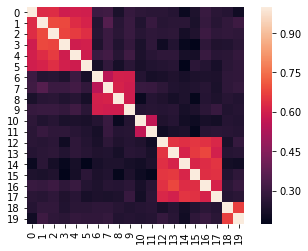

In [656]:
print('The heatmap of the correlation matrix is:')
sns.heatmap(corr0A, square = True)

## Shuffle the matrix

We shuffle the matrix to see the efficacy of ONC clustering in recovering the shuffled matrix to its initial state where Intra block correlation is high and across-block correlation is low.

In [657]:
#Initial index values
corrID = list(corr0A.index.values)
print('Order of elements before the shuffle:')
corrID

Order of elements before the shuffle:


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [658]:
#Shuffle the index
newindex = shuffle(corrID)
print('Order of elements after the shuffle:')
newindex

Order of elements after the shuffle:


[18, 5, 11, 19, 2, 10, 15, 17, 12, 4, 3, 8, 16, 14, 6, 1, 7, 9, 0, 13]

In [659]:
#Reorder the matrix based on the index values
corr1=corr0A.iloc[newindex] # reorder rows
corr1=corr1.iloc[:,newindex] # reorder columns 

print ('The shuffled matrix is:')
corr1

The shuffled matrix is:


,18,5,11,19,2,10,15,17,12,4,3,8,16,14,6,1,7,9,0,13
18,1.000000,0.263828,0.260946,0.668547,0.280958,0.255000,0.249608,0.256046,0.229901,0.266122,0.245297,0.259013,0.270041,0.217368,0.276250,0.280081,0.275961,0.245036,0.254865,0.254452
5,0.263828,1.000000,0.246489,0.278394,0.637685,0.230022,0.269657,0.225319,0.252590,0.591778,0.601137,0.224749,0.251391,0.174666,0.224652,0.611043,0.280142,0.264410,0.597612,0.259038
11,0.260946,0.246489,1.000000,0.257067,0.276671,0.566286,0.184294,0.266457,0.209445,0.261667,0.274971,0.254878,0.258615,0.236939,0.222740,0.295272,0.294484,0.260365,0.265737,0.229340
19,0.668547,0.278394,0.257067,1.000000,0.275861,0.249660,0.275353,0.264948,0.291417,0.286303,0.264008,0.249985,0.295866,0.211561,0.279039,0.307467,0.286693,0.255849,0.211239,0.260725
2,0.280958,0.637685,0.276671,0.275861,1.000000,0.258485,0.243286,0.274427,0.269307,0.662006,0.679287,0.265403,0.304738,0.220703,0.258694,0.686929,0.300156,0.297010,0.632645,0.271518
10,0.255000,0.230022,0.566286,0.249660,0.258485,1.000000,0.203468,0.216741,0.242558,0.235729,0.231847,0.198324,0.226175,0.213000,0.253477,0.245510,0.297687,0.253405,0.272651,0.256944
15,0.249608,0.269657,0.184294,0.275353,0.243286,0.203468,1.000000,0.643523,0.652152,0.220770,0.173396,0.185274,0.636300,0.617336,0.236662,0.233199,0.245617,0.237664,0.239835,0.659192
17,0.256046,0.225319,0.266457,0.264948,0.274427,0.216741,0.643523,1.000000,0.621347,0.260910,0.244143,0.239905,0.610790,0.650449,0.235136,0.260306,0.233364,0.294739,0.264540,0.604393
12,0.229901,0.252590,0.209445,0.291417,0.269307,0.242558,0.652152,0.621347,1.000000,0.276512,0.207114,0.241674,0.642476,0.639916,0.230256,0.259935,0.270529,0.257262,0.264683,0.650520
4,0.266122,0.591778,0.261667,0.286303,0.662006,0.235729,0.220770,0.260910,0.276512,1.000000,0.593995,0.257777,0.298086,0.223505,0.300254,0.633443,0.317827,0.311717,0.602699,0.276552


The heatmap of the shuffled correlation matrix is:


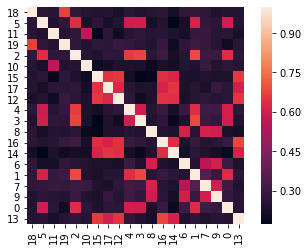

In [660]:
print('The heatmap of the shuffled correlation matrix is:')
sns.heatmap(corr1, square = True)

## ONC Execution

In [661]:
#Apply ONC algorithm on the matrix
from mlfinlab.clustering.onc import get_onc_clusters 
data2 = get_onc_clusters(corr1,10)
datatest= data2[0]
print('The resulting correlation matrix of the ONC algorithm is:')
datatest

The resulting correlation matrix of the ONC algorithm is:


,13,15,17,12,14,16,9,7,6,8,11,10,1,4,0,2,5,3,19,18
13,1.000000,0.659192,0.604393,0.650520,0.612250,0.683131,0.261942,0.247076,0.241912,0.222902,0.229340,0.256944,0.264860,0.276552,0.255949,0.271518,0.259038,0.249456,0.260725,0.254452
15,0.659192,1.000000,0.643523,0.652152,0.617336,0.636300,0.237664,0.245617,0.236662,0.185274,0.184294,0.203468,0.233199,0.220770,0.239835,0.243286,0.269657,0.173396,0.275353,0.249608
17,0.604393,0.643523,1.000000,0.621347,0.650449,0.610790,0.294739,0.233364,0.235136,0.239905,0.266457,0.216741,0.260306,0.260910,0.264540,0.274427,0.225319,0.244143,0.264948,0.256046
12,0.650520,0.652152,0.621347,1.000000,0.639916,0.642476,0.257262,0.270529,0.230256,0.241674,0.209445,0.242558,0.259935,0.276512,0.264683,0.269307,0.252590,0.207114,0.291417,0.229901
14,0.612250,0.617336,0.650449,0.639916,1.000000,0.632624,0.223340,0.239651,0.226247,0.241173,0.236939,0.213000,0.264370,0.223505,0.197786,0.220703,0.174666,0.190159,0.211561,0.217368
16,0.683131,0.636300,0.610790,0.642476,0.632624,1.000000,0.270181,0.260239,0.240346,0.256139,0.258615,0.226175,0.291965,0.298086,0.298815,0.304738,0.251391,0.274544,0.295866,0.270041
9,0.261942,0.237664,0.294739,0.257262,0.223340,0.270181,1.000000,0.595094,0.600167,0.595326,0.260365,0.253405,0.296445,0.311717,0.290666,0.297010,0.264410,0.285432,0.255849,0.245036
7,0.247076,0.245617,0.233364,0.270529,0.239651,0.260239,0.595094,1.000000,0.551727,0.610336,0.294484,0.297687,0.355760,0.317827,0.310589,0.300156,0.280142,0.299921,0.286693,0.275961
6,0.241912,0.236662,0.235136,0.230256,0.226247,0.240346,0.600167,0.551727,1.000000,0.603437,0.222740,0.253477,0.253918,0.300254,0.302941,0.258694,0.224652,0.244332,0.279039,0.276250
8,0.222902,0.185274,0.239905,0.241674,0.241173,0.256139,0.595326,0.610336,0.603437,1.000000,0.254878,0.198324,0.261825,0.257777,0.234477,0.265403,0.224749,0.246592,0.249985,0.259013


In [662]:
print('The clusters of the ONC algorithm are:')
data2[1]

The clusters of the ONC algorithm are:


{0: [15, 17, 12, 16, 14, 13],
 1: [8, 6, 7, 9],
 2: [11, 10],
 3: [5, 2, 4, 3, 1, 0],
 4: [18, 19]}

The heatmap of ONC clustered matrix is::


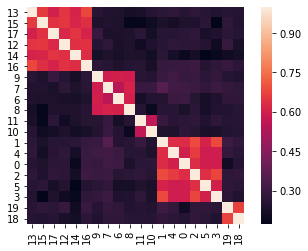

In [663]:
print('The heatmap of ONC clustered matrix is::')
sns.heatmap(datatest, square = True)

## Analysis of the results

We analyze the clustering by ONC. We assess whether ONC produces the same number of clusters to the pre-shuffled matrix number of clusters and whether ONC produces quality clustering through its Silhouette Scores. The Silhouette Score measures the similarities of objects to their clusters and dissimilarities of objects to other clusters. Silhouette score ranges from -1 to 1, where a higher score means that the object is more similar to its cluster and is more different from other clusters, and the opposite for a lower score.

According to  __Machine Learning for Asset Managers__, Marcos M. Lopez de Prado, Cornell University, New York, April 2020 the Silhouette Scores formula is:

$$S_i = \frac{b_i - a_i}{max \{a_i, b_i \}}$$

where:

$S_i$ = Silhouette Score

$a_i$ = the average distance between i and all other components in the same cluster

$b_i$ = the average distance between i and all the components in the nearest cluster where i is not included


__Preparing the necessary ONC features for analysis__

In [664]:
# Show the clusters
cldict = data2[1]
print('The elements are clustered as follows:')
cldict

The elements are clustered as follows:


{0: [15, 17, 12, 16, 14, 13],
 1: [8, 6, 7, 9],
 2: [11, 10],
 3: [5, 2, 4, 3, 1, 0],
 4: [18, 19]}

In [665]:
#Create labels for the new clustering
newlabels=np.zeros(len(datatest.columns))
listIndex = list(datatest.index)

for i in listIndex: 
    for k,v in cldict.items():
        for el in v:
            if el == i:
                newlabels[i] = k
newlabels

array([3., 3., 3., 3., 3., 3., 1., 1., 1., 1., 2., 2., 0., 0., 0., 0., 0.,
       0., 4., 4.])

In [666]:
# Get silhouette scores
silhouetteValONC = data2[2]
print('The Silhouette Scores of the ONC clustering elements are:')
silhouetteValONC

The Silhouette Scores of the ONC clustering elements are:


18    0.357328
5     0.335712
11    0.264145
19    0.360144
2     0.396447
10    0.267694
15    0.384331
17    0.366549
12    0.384872
4     0.345280
3     0.368353
8     0.318310
16    0.375942
14    0.382890
6     0.291417
1     0.380103
7     0.277724
9     0.306765
0     0.338458
13    0.386706
dtype: float64

In [667]:
#Merge all ONC Silhouette Scores into an array
appendedSilhouette = []
for i in listIndex: 
    appendedSilhouette.append(silhouetteValONC[i])
appendedSilhouette = np.array(appendedSilhouette)
appendedSilhouette

array([0.3867065 , 0.38433095, 0.36654896, 0.38487214, 0.38288984,
       0.37594238, 0.30676535, 0.27772368, 0.29141668, 0.31831004,
       0.26414474, 0.26769393, 0.3801026 , 0.34527974, 0.33845765,
       0.39644723, 0.33571222, 0.36835286, 0.36014448, 0.35732799])

__Plot The Silhouette Scores for the method__

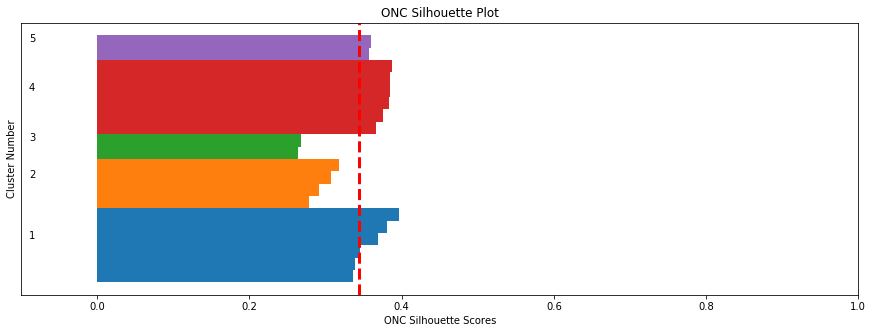

In [668]:
# ONC Silhouette Plot 
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)


y_lower, y_upper = 0, 0
for i, c in enumerate(np.unique(newlabels)):
    
        icluster_silhouette_values = appendedSilhouette[newlabels == c]
        icluster_silhouette_values.sort()
        
        y_upper += len(icluster_silhouette_values)
        ax.barh(range(y_lower, y_upper), icluster_silhouette_values, height=1)
        ax.text(-0.09, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(icluster_silhouette_values)

#Plotting the Average ONC Silhouette Scores
silavg = np.mean(silhouetteValONC.values)
ax.axvline(silavg, linestyle='--', linewidth=3, color='red')
ax.set_yticks([])
ax.set_xlim([-0.1, 1])
ax.set_xlabel('ONC Silhouette Scores')
ax.set_ylabel('Cluster Number')
ax.set_title('ONC Silhouette Plot', y=1);


## Conclusion

The ONC produces 5 clusters from the shuffled matrix. The result is consistent with the number of intended blocks in the pre-shuffled matrix that is generated by the Random Correlation Block - Matrices Algorithm. The average Silhouette Score is around 0.35, and 3 out of 5 clusters have approximately better than average Silhouette Scores.